# Predicting football transfer fees based on publicly available data

## Importing modules

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib, matplotlib.pyplot as plt, sklearn

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PoissonRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

matplotlib.rcParams['figure.figsize'] = (15, 10)

## Reading and preparing data

In [2]:
df = pd.read_csv('./data/full_dataset.csv', parse_dates=True, index_col=0, skipinitialspace=True, )
df = df.drop(['player_id_x', 'player_id_y','team_id_giving_team', 'team_id_receiving_team', 'goals_conceded', 'clean_sheets', 'places_of_birth', 'country_of_birth', 'national_debuts_y'], axis=1)
df = df[df['transfer_values'] != '?']

# As contract length for older seasons are unreliable I drop all "free" transfers, as they otherwise bias the dataset
df = df[df['transfer_values'] != '-']
df = df[df['transfer_values'] != 'ablösefrei']

# Winter transfers for 2020 are not completed, yet
mask = (df['season'] == 2020) & (df['period'] == 'w')
df = df[~mask]
df['positions'] = df['positions'].str.strip()
df = df[~(df['positions'] ==  'Torwart')]
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (339,340,341) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,season,period,player_ids,giving_team_ids,receiving_team_ids,transfer_values,matches,goals,assists,yellow_cards,...,avg_defenders_age_receiving_team,mitfielder_receiving_team,avg_mitfielders_age_receiving_team,striker_receiving_team,avg_strikers_age_receiving_team,final_table_position_receiving_team,no_of_matches_receiving_team,goal_diff_receiving_team,points_receiving_team,Vertrag bis
0,2000,s,127,506,16,"7,50 Mio. €",19.0,1.0,0.0,3.0,...,"27,11",10,"25,00",8,"26,00",11.0,34.0,3.0,40.0,-
1,2000,s,113,430,16,"4,10 Mio. €",41.0,2.0,3.0,6.0,...,"27,11",10,"25,00",8,"26,00",11.0,34.0,3.0,40.0,-
3,2000,s,123,91,16,200 Tsd. €,32.0,4.0,0.0,4.0,...,"27,11",10,"25,00",8,"26,00",11.0,34.0,3.0,40.0,-
4,2000,s,97,2035,15,"4,50 Mio. €",0.0,0.0,0.0,0.0,...,"24,50",13,"23,92",7,"24,43",2.0,34.0,38.0,73.0,NaN
5,2000,s,83,3,15,"2,10 Mio. €",35.0,3.0,1.0,5.0,...,"24,50",13,"23,92",7,"24,43",2.0,34.0,38.0,73.0,-


In [3]:
# Setting correct data types
df['transfer_values'] = df['transfer_values'].str.replace(' Mio. €', '0000').str.replace(' Tsd. €', '000').str.replace(',', '')
df['dates_of_birth'] = df['dates_of_birth'].str[:10]
df['sizes'] = df['sizes'].str.replace('m', '').str.replace(',', '').str.strip()
avg_ages = ['avg_keepers_age_giving_team', 'avg_defenders_age_giving_team', 
            'avg_mitfielders_age_giving_team', 'avg_strikers_age_giving_team',
           'avg_keepers_age_receiving_team', 'avg_defenders_age_receiving_team', 
            'avg_mitfielders_age_receiving_team', 'avg_strikers_age_receiving_team'
           ]
for col in avg_ages:
    df[col] = df[col].str.replace(',', '.')
df['dates_of_birth'] = pd.to_datetime(df['dates_of_birth'], errors='coerce')
cols = ['transfer_values', 'matches', 'goals', 'assists', 'yellow_cards', 
        'yellow_red_cards', 'red_cards', 'minutes_played', 'sizes',
       'avg_keepers_age_giving_team', 'avg_defenders_age_giving_team', 
        'avg_mitfielders_age_giving_team', 'avg_strikers_age_giving_team',
       'avg_keepers_age_receiving_team', 'avg_defenders_age_receiving_team', 
        'avg_mitfielders_age_receiving_team', 'avg_strikers_age_receiving_team'
       ]
df[cols] = df[cols].replace('-', 0)
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df.rename(columns={'Vertrag bis':'contract_until', 'national_debuts_x' : 'national_debuts'}, inplace=True)

In [4]:
# filling nans
df['consultants'] = np.where(df.consultants.isna(), 0, 1)
for sm in ['twitter', 'facebook', 'instagram', 'homepage']:
    df[sm] = df[sm].fillna('')
df['social_media'] = df['twitter'] + df['facebook'] + df['instagram'] + df['homepage']
df['social_media'] = np.where(df.social_media == '' ,0,1)
for col in avg_ages:
    df[col] = df[col].fillna(df[col].median())
giving_team_stats = ['final_table_position_giving_team', 'no_of_matches_giving_team', 'goal_diff_giving_team', 'points_giving_team']
for col in giving_team_stats:
    df[col].replace('-', np.nan, inplace=True)
    df[col] = df[col].astype('float')
    df[col].fillna(df.groupby(['giving_team_ids'])[col].transform('median'),inplace=True)
    df[col] = df[col].fillna(df[col].median())
receiving_team_stats = ['final_table_position_receiving_team', 'no_of_matches_receiving_team', 'goal_diff_receiving_team', 'points_receiving_team']
for col in receiving_team_stats:
    df[col].replace('-', np.nan, inplace=True)
    df[col] = df[col].astype('float')
    df[col].fillna(df.groupby(['receiving_team_ids'])[col].transform('median'),inplace=True)
    df[col] = df[col].fillna(df[col].median())

df['sizes'] = df['sizes'].fillna(df['sizes'].median())
df['secondary_posistions'] = np.where(df['secondary_posistions'].isna(), 0, 1)
df['outfitters'] = np.where(df['outfitters'].isna(), 0, 1)
df['strong_feet'] = df['strong_feet'].fillna('rechts')
df['month_of_period'] = np.where(df.period == 's' , 7, 12)
df['age_at_transfer'] = (pd.to_datetime(dict(year=df.season, month=df.month_of_period, day=1)) - df['dates_of_birth']).dt.days
df['age_at_transfer'] = df['age_at_transfer'].fillna(df['age_at_transfer'].median())
df['time_line'] = df['season'].astype('int')- 1999

for i in range(len(df)):
    if pd.isna(df['contract_until'].iloc[i]):
        df['contract_until'].iloc[i] = f'30.06.{df["season"].iloc[i] +1}'
    if df['contract_until'].iloc[i] == '-':
        df['contract_until'].iloc[i] = f'30.06.{df["season"].iloc[i] +1}'       


df['contract_until'] = pd.to_datetime(df['contract_until'], format='%d.%m.%Y', errors='coerce')
df['contract_length'] = df['contract_until'].dt.year - df['season']


df['national_debuts'] = pd.to_datetime(df['national_debuts'], format='%d.%m.%Y', errors='coerce')
df['national_debuts'] = df['national_debuts'].dt.year - df['season']
df['national_debuts'] = np.where(df['national_debuts'] < 0, 1, 0)

df['positions'] = df['positions'].apply(lambda x: 'defense' if 'Abwehr' in str(x) 
                                                      else 'midfield' if 'Mittelfeld' in str(x) 
                                                      else 'striker' if 'Sturm' in str(x)
                                                      else x)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
df.drop(['twitter', 'facebook', 'instagram', 'homepage', 'month_of_period', 'dates_of_birth', 'contract_until'], inplace=True, axis=1)

In [6]:
df.drop_duplicates(inplace=True)

## Defining train and test data

I keep the Corona season seperated, as I expect it to be an outlier. This way enables later comparison

In [7]:
# defining X and y
train = df.loc[(df['season'] <= 2018)]
test = df[df['season'] == 2019]
train_corona = df.loc[(df['season'] <= 2019)]
test_corona = df[df['season'] == 2020]

# main data
y_train = np.log(train['transfer_values'])
X_train = train.loc[:, train.columns != 'transfer_values']
y_test = test['transfer_values']
X_test = test.loc[:, test.columns != 'transfer_values']

# corona comparison
y_train_corona = np.log(train_corona['transfer_values'])
X_train_corona = train_corona.loc[:, train_corona.columns != 'transfer_values']
y_test_corona = test_corona['transfer_values']
X_test_corona = test_corona.loc[:, test_corona.columns != 'transfer_values']

## Grafical analyses

### Transfer expenditure of the Bundesliga over time

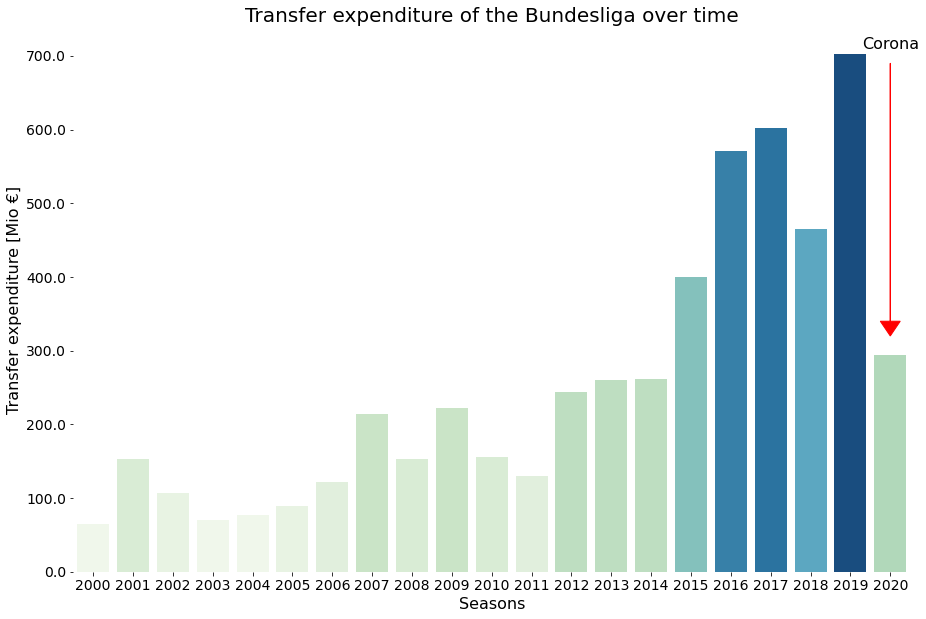

In [115]:
fig = plt.figure() 
ax = fig.add_subplot(111)

spending_over_time = pd.DataFrame(df[df['period']=='s'].groupby('season')['transfer_values'].sum())
pal = sns.color_palette("GnBu", len(spending_over_time))

def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

ax = sns.barplot(x=spending_over_time.index, 
            y= spending_over_time['transfer_values'], 
            palette=colors_from_values(spending_over_time['transfer_values'], "GnBu"),
           ax=ax)

title_font = {'family': 'league-gothic',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
ax_font = {'family': 'league-gothic',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
ticker_font = {'family': 'league-gothic',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

ax.set_title('Transfer expenditure of the Bundesliga over time', fontdict = title_font) 
ax.set_xlabel('Seasons', fontdict = ax_font)
ax.set_ylabel('Transfer expenditure [Mio €]', fontdict = ax_font, size = 16)
ax.set_xticklabels(labels = spending_over_time.index, fontdict = ticker_font)
ax.set_yticklabels(labels = ax.get_yticks()/1000000, fontdict = ticker_font)

ax.arrow(20, 690000000, 0, -350000000, head_width=0.5, head_length=20000000, fc='red', ec='red')
ax.annotate('Corona', (19.3, 710000000), fontfamily = 'league-gothic', color = 'black', fontsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('./presentation/assets/expenditure_over_time.png', transparent=True)


### Number of transfers in to the Bundesliga per season 

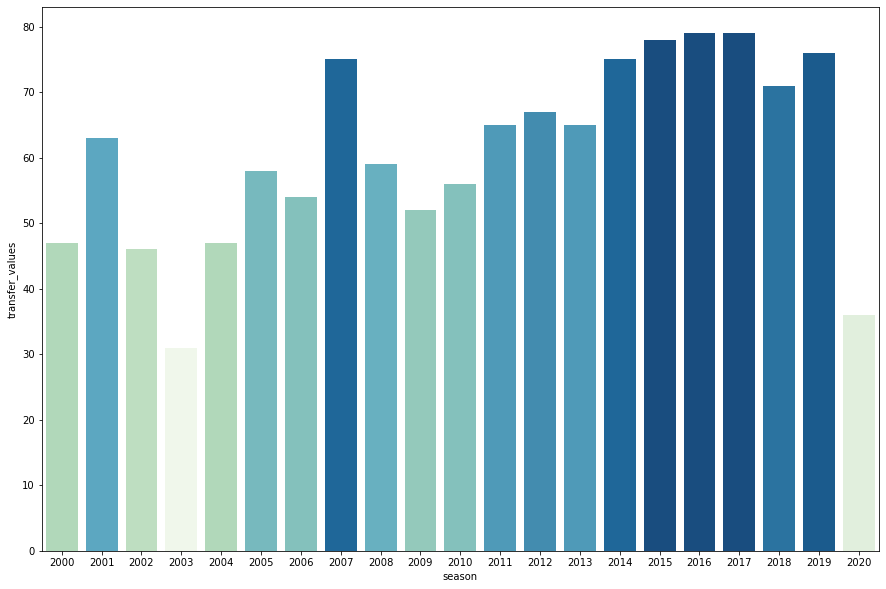

In [9]:
transfer_count = pd.DataFrame(df[df['period']=='s'].groupby('season')['transfer_values'].count())#.plot(x='season', y='transfer_values', kind='bar')

sns.barplot(x = transfer_count.index, y = transfer_count['transfer_values'], palette=colors_from_values(transfer_count['transfer_values'], "GnBu"))

While the number of (fee) transfers were slowly increasing over time, corona lead to a sudden drop in the number of fee transfers. The clubs seem to be reluctant to act big on the transfermakrt 

### Comparison of average summer vs. winter transfer fee per player

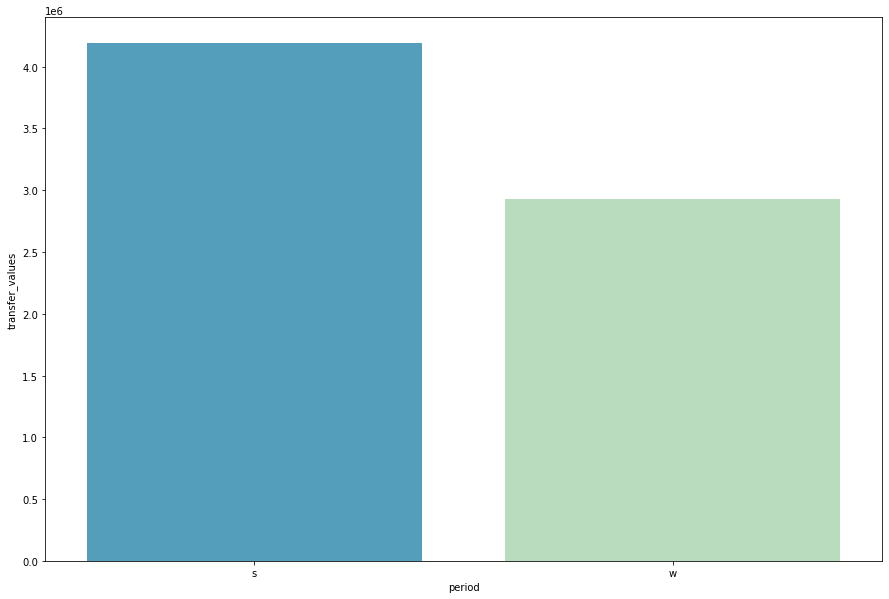

In [10]:
period_avg = pd.DataFrame(df.groupby('period')['transfer_values'].mean())
sns.barplot(x = period_avg.index, y = period_avg['transfer_values'], palette=colors_from_values(period_avg['transfer_values'], "GnBu"))


Significant transfers tend to be made in the summer transfer period

## Machine learning
The Dummy-Regression gives a first estimate to compare other models to. It does not lead to a meaningful prediction, but only takes the mean value of all test labels.
After thtat I try a Random Forest and a Ridge regression model and the combined predicitions of both models. In a previous notebook I also tried out a Poisson regression, which did not yield satisfactionary results, so I dropped it for an improved overview

### DummyRegressor

In [11]:
DR = DummyRegressor(strategy='mean')

In [12]:
DR.fit(X_train, y_train)

DummyRegressor()

In [13]:
y_pred_DR = np.exp(DR.predict(X_test))

In [14]:
mean_squared_log_error(y_pred_DR, y_test)

3.1316873316014124

The MSLE of 3.13 seves as a baseline. Any model that does not yiled significantly better predictions should be dropped

### Random Forest

In [15]:
passthrough_cols = [col for col in df if col.startswith('competition_id_')]
passthrough_cols.append('secondary_posistions')
passthrough_cols.append('consultants')
passthrough_cols.append('outfitters')
passthrough_cols.append('social_media')

giving_team_cols = [col for col in df if col.endswith('_giving_team')]
receiving_team_cols = [col for col in df if col.endswith('_receiving_team')]
stand_scale_cols = []
stand_scale_cols.extend(giving_team_cols)
stand_scale_cols.extend(receiving_team_cols)
stand_scale_cols.append('contract_length')

In [16]:
## make_pipelien & make_column_transformer
age_pipe = make_pipeline(StandardScaler(),
                         PolynomialFeatures()
                         )

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False, drop = 'first'), ['period', 'positions', 'strong_feet']),
    (OneHotEncoder(sparse=False, handle_unknown= 'ignore'), ['nationalities', 
                                                             'player_ids', 
                                                            'giving_team_ids',
                                                            'receiving_team_ids']),
    (age_pipe, ['age_at_transfer']),
    (PolynomialFeatures(), ['time_line']),
     (StandardScaler(), stand_scale_cols),
     ('passthrough', passthrough_cols)
)

In [17]:
# make_pipeline
RF_pipeline = make_pipeline(
                            transformer,
                            PolynomialFeatures(degree=1, interaction_only=True),
                            RandomForestRegressor(n_estimators=500, verbose = 1)
                            )

In [18]:
# grid
grid_RF = {
    'randomforestregressor__max_depth':[15, 25, 40],
}


In [19]:
# grid_search
scores_RF_reg = GridSearchCV(
    estimator=RF_pipeline,
    param_grid=grid_RF,
    scoring= 'neg_mean_squared_error',
    cv=3, 
    n_jobs= 4,
    verbose=True,
    return_train_score=True
)

In [20]:
%%time
%%capture
scores_RF_reg.fit(X_train, y_train)

CPU times: user 34.3 s, sys: 153 ms, total: 34.5 s
Wall time: 1min 35s


In [21]:
# analyze the output
cv_results_RF_reg = pd.DataFrame(scores_RF_reg.cv_results_)
cv_results_RF_reg[[
    'rank_test_score',
    'mean_test_score', 
    'mean_train_score',
    'param_randomforestregressor__max_depth'
    ]].sort_values('rank_test_score')


,rank_test_score,mean_test_score,mean_train_score,param_randomforestregressor__max_depth
2,1,-1.315139,-0.133179,40
1,2,-1.321571,-0.135170,25
0,3,-1.324489,-0.180649,15


In [22]:
%%capture
# fit using best estimators
scores_RF_reg.best_estimator_.fit(X_train, y_train)

In [64]:
y_pred = np.exp(scores_RF_reg.predict(X_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


## Ridge Regression

In [42]:
RR_pipeline = make_pipeline(
                            transformer,
                            PolynomialFeatures(),
                            Ridge()
                            )

In [46]:
# grid
grid_RR = {
    'ridge__alpha':[0.1, 1],
    'polynomialfeatures__degree': [1,2]
}

In [47]:
# grid_search
scores_RR_reg = GridSearchCV(
    estimator=RR_pipeline,
    param_grid=grid_RR,
    scoring= 'neg_mean_squared_error',
    cv=3, 
    n_jobs= 4,
    verbose=True,
    return_train_score=True
)

In [48]:
%%time
%%capture
scores_RR_reg.fit(X_train, y_train)

CPU times: user 1.84 s, sys: 294 ms, total: 2.14 s
Wall time: 8min 43s


In [51]:
# analyze the output
cv_results_RR_reg = pd.DataFrame(scores_RR_reg.cv_results_)
cv_results_RR_reg[[
    'rank_test_score',
    'mean_test_score', 
    'mean_train_score',
    'param_ridge__alpha',
    'param_polynomialfeatures__degree'
    ]].sort_values('rank_test_score')


,rank_test_score,mean_test_score,mean_train_score,param_ridge__alpha,param_polynomialfeatures__degree
1,1,-1.130898,-1.039410e-01,1,1
0,2,-1.181287,-1.082738e-02,0.1,1
2,3,-15.405439,-1.922217e-08,0.1,2
3,4,-15.410202,-1.900802e-06,1,2


In [52]:
%%capture
# fit using best estimators
scores_RR_reg.best_estimator_.fit(X_train, y_train)

In [62]:
y_pred_RR = np.exp(scores_RR_reg.predict(X_test))

### Comparing the results

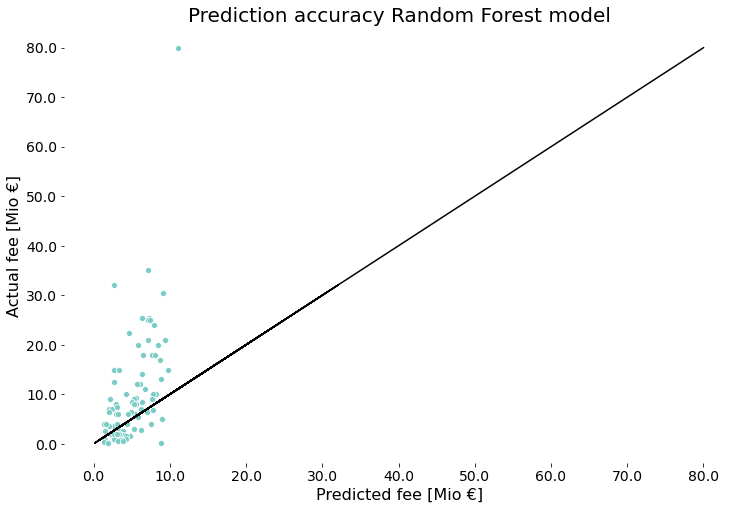

In [76]:
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot()
pal = sns.color_palette("GnBu", 1)
sns.scatterplot(y_pred, y_test, c = pal, ax=ax)
ax.plot(y_test, y_test, c = 'black')


ax.set_title('Prediction accuracy Random Forest model', fontdict = title_font) 
ax.set_xlabel('Predicted fee [Mio €]', fontdict = ax_font)
ax.set_ylabel('Actual fee [Mio €]', fontdict = ax_font)
ax.set_xticklabels(labels = ax.get_xticks()/1000000, fontdict = ticker_font)
ax.set_yticklabels(labels = ax.get_yticks()/1000000, fontdict = ticker_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('./presentation/assets/model_accuracy_RF.png', transparent=True)

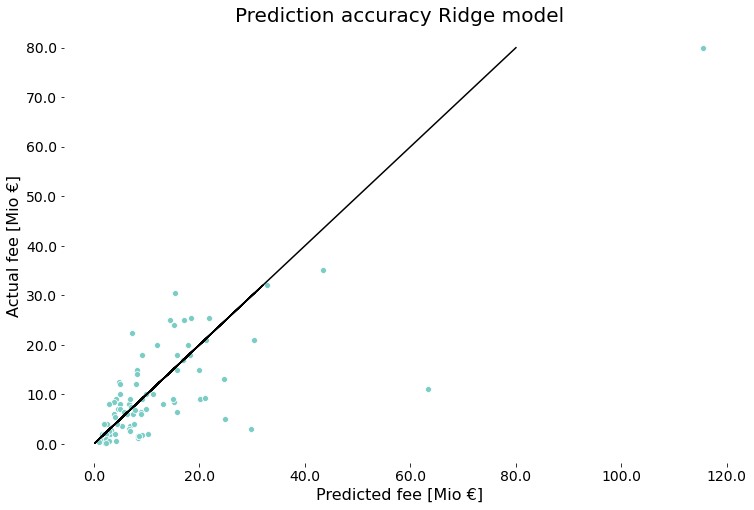

In [73]:
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot()
pal = sns.color_palette("GnBu", 1)
sns.scatterplot(y_pred_RR, y_test, c = pal, ax=ax)
ax.plot(y_test, y_test, c = 'black')

ax.set_title('Prediction accuracy Ridge model', fontdict = title_font) 
ax.set_xlabel('Predicted fee [Mio €]', fontdict = ax_font)
ax.set_ylabel('Actual fee [Mio €]', fontdict = ax_font)
ax.set_xticklabels(labels = ax.get_xticks()/1000000, fontdict = ticker_font)
ax.set_yticklabels(labels = ax.get_yticks()/1000000, fontdict = ticker_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('./presentation/assets/model_accuracy_RR.png', transparent=True)

**--> While the Random Forest regression model tends to underestimate transfer fees of high value, the Ridge regression model does exactly the opposite. A solution could be to combine both models to average out the systematic errors of both models**

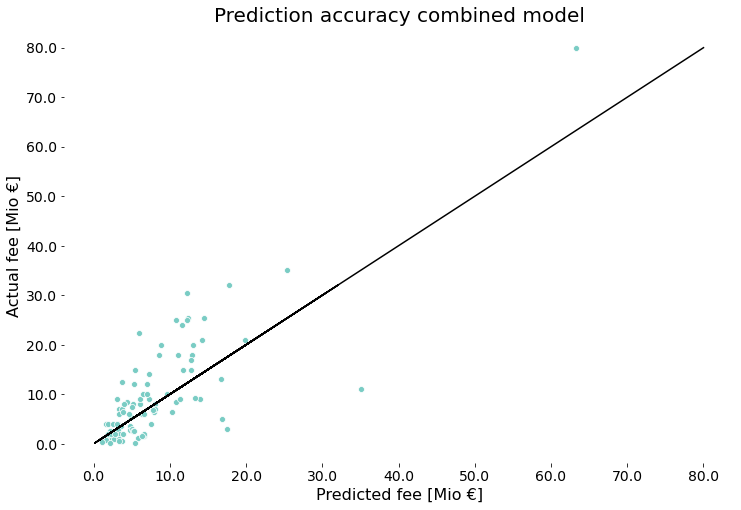

In [74]:
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot()
pal = sns.color_palette("GnBu", 1)
sns.scatterplot((y_pred + y_pred_RR)/2, y_test, c = pal, ax=ax)
ax.plot(y_test, y_test, c = 'black')

ax.set_title('Prediction accuracy combined model', fontdict = title_font) 
ax.set_xlabel('Predicted fee [Mio €]', fontdict = ax_font)
ax.set_ylabel('Actual fee [Mio €]', fontdict = ax_font)
ax.set_xticklabels(labels = ax.get_xticks()/1000000, fontdict = ticker_font)
ax.set_yticklabels(labels = ax.get_yticks()/1000000, fontdict = ticker_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('./presentation/assets/model_accuracy_RR.png', transparent=True)

The error still increases with the fee value but we do not observe a systematic under- or overestimation anymore. Let's see how that represents in the MSLE values:

In [77]:
mean_squared_log_error(y_pred, y_test)

1.097078420719095

In [60]:
mean_squared_log_error(y_pred_RR, y_test)

0.7743515902673264

In [61]:
mean_squared_log_error((y_pred_RR+y_pred)/2, y_test)

0.7581683411287778

## Corona predictioins
As a bonus I'd like to analyze how Corona impacts the transfer market as a general and the prediction model. This part is still work in progress

### Random Forest

In [78]:
# grid
grid_RF_corona = {
    'randomforestregressor__max_depth':[10, 25, 40],
}

In [79]:
scores_RF_reg_corona = GridSearchCV(
    estimator=RF_pipeline,
    param_grid=grid_RF_corona,
    scoring= 'neg_mean_squared_error',
    cv=3, 
    n_jobs= 4,
    verbose=True,
    return_train_score=True
)

In [98]:
%%time
%%capture
scores_RF_reg_corona.fit(X_train_corona, y_train_corona)

CPU times: user 43 s, sys: 231 ms, total: 43.3 s
Wall time: 1min 51s


In [81]:
# analyze the output
cv_results_RF_reg_corona = pd.DataFrame(scores_RF_reg_corona.cv_results_)
cv_results_RF_reg_corona[[
    'rank_test_score',
    'mean_test_score', 
    'mean_train_score',
    'param_randomforestregressor__max_depth',
    ]].sort_values('rank_test_score')

,rank_test_score,mean_test_score,mean_train_score,param_randomforestregressor__max_depth
2,1,-1.348218,-0.130430,40
1,2,-1.349301,-0.133278,25
0,3,-1.362615,-0.345687,10


In [82]:
%%capture
# fit using best estimators
scores_RF_reg_corona.best_estimator_.fit(X_train_corona, y_train_corona)

In [83]:
y_pred_corona = np.exp(scores_RF_reg_corona.predict(X_test_corona))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


## Ridge Regression

In [85]:
# grid
grid_RR_corona = {
    'ridge__alpha':[0.1, 1],
    'polynomialfeatures__degree': [1, 2]
}


In [86]:
scores_RR_reg_corona = GridSearchCV(
    estimator=RR_pipeline,
    param_grid=grid_RR_corona,
    scoring= 'neg_mean_squared_error',
    cv=3, 
    n_jobs= 4,
    verbose=True,
    return_train_score=True
)

In [95]:
%%time
%%capture
scores_RR_reg_corona.fit(X_train_corona, y_train_corona)

CPU times: user 1.86 s, sys: 223 ms, total: 2.08 s
Wall time: 29min 45s


In [88]:
# analyze the output
cv_results_RR_reg_corona = pd.DataFrame(scores_RR_reg_corona.cv_results_)
cv_results_RR_reg_corona[[
    'rank_test_score',
    'mean_test_score', 
    'mean_train_score',
    'param_ridge__alpha',
    'param_polynomialfeatures__degree'
    ]].sort_values('rank_test_score')

,rank_test_score,mean_test_score,mean_train_score,param_ridge__alpha,param_polynomialfeatures__degree
1,1,-1.126507,-1.060507e-01,1,1
0,2,-1.300106,-1.196795e-02,0.1,1
3,3,-11.868989,-1.809901e-06,1,2
2,4,-11.883150,-1.830342e-08,0.1,2


In [89]:
%%capture
# fit using best estimators
scores_RR_reg_corona.best_estimator_.fit(X_train_corona, y_train_corona)

In [96]:
y_pred_corona_RR = np.exp(scores_RR_reg_corona.predict(X_test_corona))

### Comparing model results

In [91]:
# Random Forest
mean_squared_log_error(y_pred_corona, y_test_corona)

0.6367274075428507

In [99]:
# Ridge
mean_squared_log_error(y_pred_corona_RR, y_test_corona)

0.696719978386236

In [93]:
# Combined models
mean_squared_log_error((y_pred_corona_RR+y_pred_corona)/2, y_test_corona)

0.5206066685175178

Again, the combined model yields the best predicitons

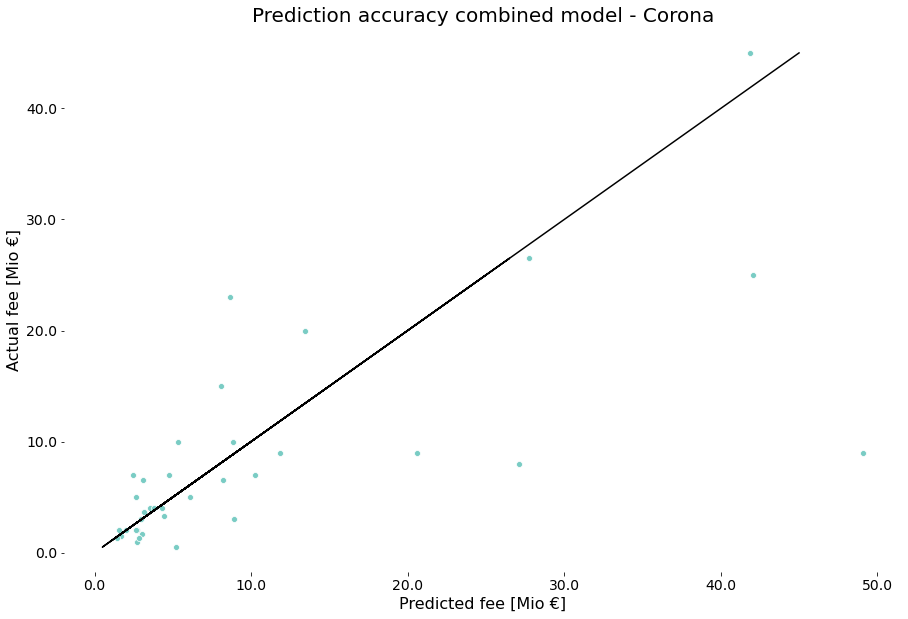

In [97]:
fig = plt.figure(figsize=(15, 10)) 
ax = fig.add_subplot()
pal = sns.color_palette("GnBu", 1)
sns.scatterplot((y_pred_corona_RR+y_pred_corona)/2, y_test_corona, c = pal, ax=ax)
ax.plot(y_test_corona, y_test_corona, c = 'black')

ax.set_title('Prediction accuracy combined model - Corona', fontdict = title_font) 
ax.set_xlabel('Predicted fee [Mio €]', fontdict = ax_font)
ax.set_ylabel('Actual fee [Mio €]', fontdict = ax_font)
ax.set_xticklabels(labels = ax.get_xticks()/1000000, fontdict = ticker_font)
ax.set_yticklabels(labels = ax.get_yticks()/1000000, fontdict = ticker_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('./presentation/assets/corona_model_accuracy_combinded.png', transparent=True)

### Preparing the output

In [114]:
results_df = pd.DataFrame({'period':X_test['period'],
                            'player_id': X_test['player_ids'],
                           'receiving_team_id': X_test['receiving_team_ids'],
                           'position': X_test['positions'],
                            'actual_values':y_test,
                          'RF_prediction': y_pred.round(),
                           'RR_prediction': y_pred_RR.round()
                          })

results_df['position'] = results_df['position'].apply(lambda x: 'defense' if 'Abwehr' in str(x) 
                                                      else 'midfield' if 'Mittelfeld' in str(x) 
                                                      else 'striker' if 'Sturm' in str(x)
                                                      else x)
results_df['combined_prediction'] = (results_df['RF_prediction'] + results_df['RR_prediction'])/2
results_df['delta'] = results_df['actual_values'] - results_df['combined_prediction']
results_df['percentual_deviation'] = round(results_df['delta'] / results_df['actual_values'], 3)*100
results_df.to_csv('results.csv', encoding = 'utf-8')
results_df

,period,player_id,receiving_team_id,position,actual_values,RF_prediction,RR_prediction,combined_prediction,delta,percentual_deviation
2510,s,281963,27,defense,80000000.0,11083338.0,115561348.0,63322343.0,16677657.0,20.8
2511,s,353366,27,defense,35000000.0,7092906.0,43509945.0,25301425.5,9698574.5,27.7
2512,s,344600,27,midfield,8000000.0,2985485.0,13160612.0,8073048.5,-73048.5,-0.9
2513,s,343337,27,striker,3000000.0,5358706.0,29679074.0,17518890.0,-14518890.0,-484.0
2514,s,39728,16,defense,30500000.0,9056281.0,15428234.0,12242257.5,18257742.5,59.9
...,...,...,...,...,...,...,...,...,...,...
2634,w,327757,44,striker,24000000.0,7924165.0,15195581.0,11559873.0,12440127.0,51.8
2635,w,517894,44,striker,18000000.0,6537369.0,15660612.0,11098990.5,6901009.5,38.3
2636,w,423436,44,midfield,10000000.0,4189909.0,9822379.0,7006144.0,2993856.0,29.9
2637,w,240408,127,midfield,400000.0,1371277.0,872585.0,1121931.0,-721931.0,-180.5


In [100]:
results_df_corona = pd.DataFrame({'player_id': X_test_corona['player_ids'],
                           'receiving_team_id': X_test_corona['receiving_team_ids'],
                           'position': X_test_corona['positions'],
                            'actual_values':y_test_corona,
                           'RF_prediction': y_pred_corona.round(),
                           'RR_prediction': y_pred_corona_RR.round()
                          })

results_df_corona['position'] = results_df_corona['position'].apply(lambda x: 'defense' if 'Abwehr' in str(x) 
                                                      else 'midfield' if 'Mittelfeld' in str(x) 
                                                      else 'striker' if 'Sturm' in str(x)
                                                      else x)
results_df_corona['combined_prediction'] = (results_df_corona['RF_prediction'] + results_df_corona['RR_prediction'])/2
results_df_corona['delta'] = results_df_corona['actual_values'] - results_df_corona['combined_prediction']
results_df_corona['percentual_deviation'] = round(results_df_corona['delta'] / results_df_corona['actual_values'], 3)*100
results_df_corona.to_csv('results_corona.csv', encoding = 'utf-8')

In [101]:
results_df_corona.round().style.format({'actual_values':'{:,}', 
                                'RF_prediction':'{:,}', 
                                'RR_prediction':'{:,}', 
                                'combined_prediction':'{:,}', 
                                'delta':'{:,}',
                               'percentual_deviation':'{:,}'})

,player_id,receiving_team_id,position,actual_values,RF_prediction,RR_prediction,combined_prediction,delta,percentual_deviation
2640,192565,27,striker,"45,000,000.0","19,484,833.0","64,244,720.0","41,864,776.0","3,135,224.0",7.0
2641,336869,27,midfield,"9,000,000.0","15,143,470.0","83,065,418.0","49,104,444.0","-40,104,444.0",-446.0
2645,190685,27,defense,"8,000,000.0","15,528,220.0","38,717,150.0","27,122,685.0","-19,122,685.0",-239.0
2655,119296,16,midfield,"25,000,000.0","17,008,563.0","67,164,171.0","42,086,367.0","-17,086,367.0",-68.0
2656,581678,16,midfield,"23,000,000.0","7,962,487.0","9,369,347.0","8,665,917.0","14,334,083.0",62.0
2658,238407,23826,striker,"20,000,000.0","12,646,130.0","14,234,739.0","13,440,434.0","6,559,566.0",33.0
2659,292246,23826,striker,"9,000,000.0","11,498,081.0","29,713,261.0","20,605,671.0","-11,605,671.0",-129.0
2661,528833,23826,midfield,"500,000.0","6,921,337.0","3,473,998.0","5,197,668.0","-4,697,668.0",-940.0
2662,242086,15,striker,"26,500,000.0","8,413,362.0","47,073,603.0","27,743,482.0","-1,243,482.0",-5.0
2664,215864,533,midfield,"3,000,000.0","4,502,738.0","13,333,829.0","8,918,284.0","-5,918,284.0",-197.0


## Analyzing where the deviation comes from

In [128]:
# preparing dfs
deviation_restults = results_df
deviation_restults['percentual_deviation'] = abs(deviation_restults['percentual_deviation'])

team_names = pd.read_csv('./data/raw_overview_results.csv', index_col=0)
team_names = team_names[['receiving_team_ids','receiving_team_names']].drop_duplicates()
team_names['receiving_team_names'] = team_names.receiving_team_names.str.replace('-', ' ').str.title().str.replace('Fc', 'FC').str.replace('Sv', 'SV').str.replace('Sc ', 'SC ')
team_variance = pd.DataFrame(deviation_restults.groupby('receiving_team_id')['percentual_deviation', 'delta'].mean())
team_variance = team_variance.reset_index().merge(team_names, how = 'left', left_on = 'receiving_team_id', right_on = 'receiving_team_ids').set_index('receiving_team_names')
team_variance.drop(['receiving_team_ids', 'receiving_team_id'], axis=1, inplace=True)
team_variance = team_variance.sort_values(by='percentual_deviation')
team_variance

<ipython-input-128-826d2b22aaeb>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  team_variance = pd.DataFrame(deviation_restults.groupby('receiving_team_id')['percentual_deviation', 'delta'].mean())


,percentual_deviation,delta
receiving_team_names,,
SV Werder Bremen,13.350000,-8.046970e+05
1 FC Koln,23.925000,1.993016e+05
Rasenballsport Leipzig,33.320000,3.206159e+06
1 Fsv Mainz 05,40.340000,1.788373e+06
Hertha Bsc,41.642857,6.992257e+06
Borussia Dortmund,41.933333,1.078535e+07
Fortuna Dusseldorf,42.650000,-1.497074e+06
SC Freiburg,63.400000,-9.518470e+05
FC Schalke 04,64.133333,-1.077546e+06


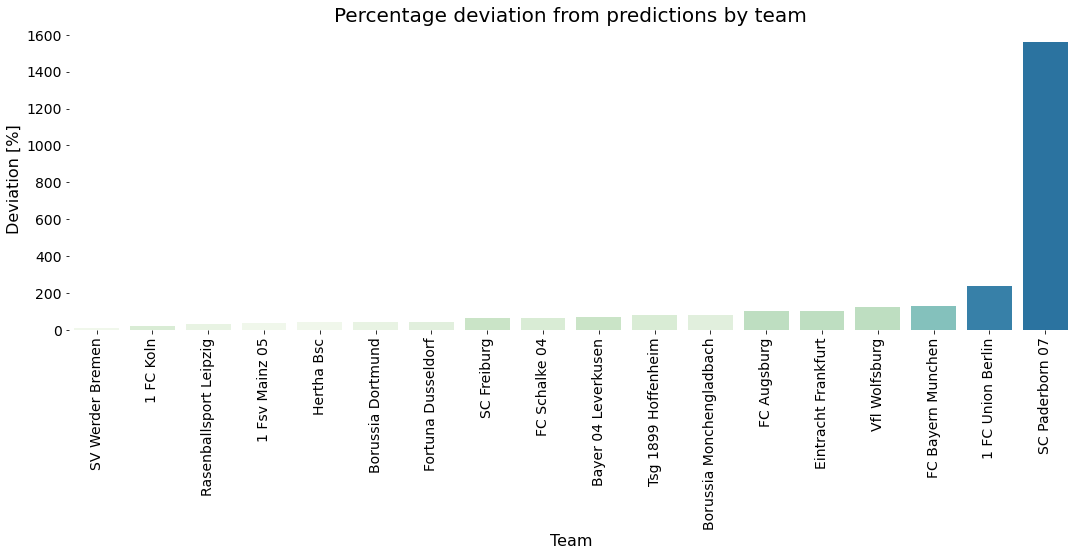

In [129]:
fig = plt.figure(figsize = (18, 15)) 
ax = fig.add_subplot(111)
ax = sns.barplot(x=team_variance.index, 
            y= team_variance['percentual_deviation'], 
            palette=colors_from_values(spending_over_time['transfer_values'], "GnBu"),
            ax=ax)

ax.set_title('Percentage deviation from predictions by team', fontdict = title_font) 
ax.set_xlabel('Team', fontdict = ax_font)
ax.set_ylabel('Deviation [%]', fontdict = ax_font)
ax.set_xticklabels(labels = team_variance.index, fontdict = ticker_font, rotation = 'vertical')
plt.subplots_adjust(bottom=0.6)
ax.set_yticklabels(labels = ax.get_yticks().astype('int'), fontdict = ticker_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('./presentation/assets/deviations_per_team.png', transparent=True)

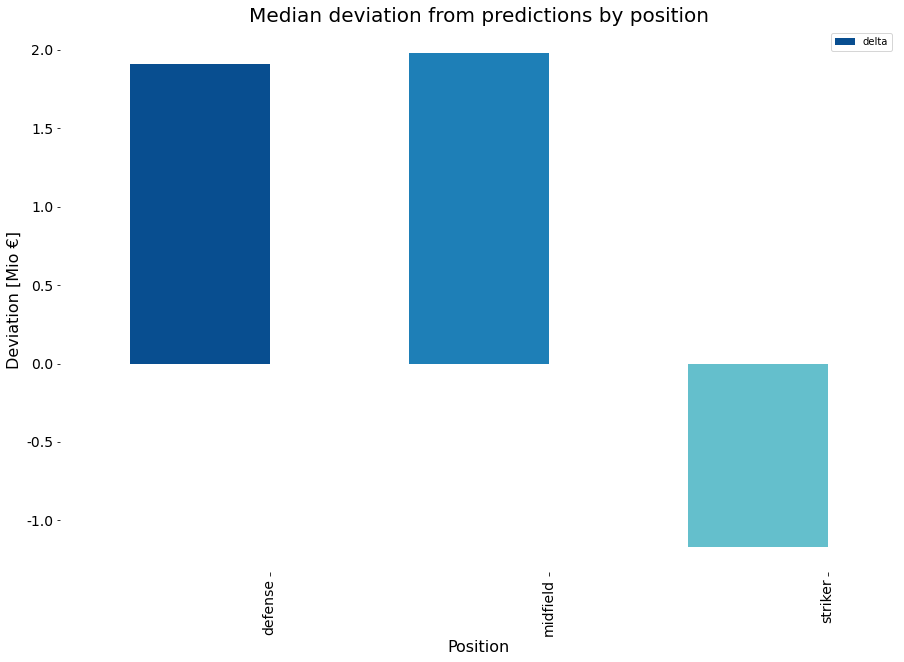

In [149]:
fig = plt.figure() 
ax = fig.add_subplot(111)

ax = deviation_restults.groupby('position')['delta'].median().plot(kind='bar', 
                                                                  ax=ax,
                                                                  position=1,
                                                                color = colors_from_values(deviation_restults['delta'], "GnBu"))
ax.legend()
ax.set_title('Median deviation from predictions by position', fontdict = title_font) 
ax.set_xlabel('Position', fontdict = ax_font)
ax.set_ylabel('Deviation [Mio €]', fontdict = ax_font)
ax.set_xticklabels(labels = deviation_restults.groupby('position')['delta'].median().index, fontdict = ticker_font, rotation = 'vertical')
ax.set_yticklabels(labels = ax.get_yticks().astype('int')/ 1000000, fontdict = ticker_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)